# Learning fMRI from simultaneous EEG recordings

<img src="EEGtofMRI.png">

*EEG (avg or FCz referenced) to fMRI BOLD translation (fMRI with Harvard-Oxford Parcellated based on MNI152 space)*


This notebook details filtering, feature extraction and basic model training for a simple feedforward ANN for predicting fMRI BOLD signal from simultaneous EEG recordings. The program uses simple festures such as energy in the delta through to gamma bands as predictors (delta band power has shown to be correlated with cortical BOLD in resting wakefulness). Other possible features include low average frequency IMFs from EMD-based analysis and information theoretic features (e.g. LZ complexity and entropy).

This code was originally designed for real simultaneously aquired EEG/fMRI signal from wakeful and anaesthetised subjects. In lieu of real data, pairwise uncorrelated multidimensional pink noise is used to simulate EEG/fMRI signal after initial PCA. Other architectures such as RNNs may lead to better performance on real (non-simulated data).

High dimensional fMRI data is assumed to have been first registered to a standard space model and then dimensionally reduced by anatomical or functional parcellation. An example of which is shown above (right).

In [1]:
import tensorflow as tf
import mne#a package for analysing EEG data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter,lfilter
from lspopt.lsp import spectrogram_lspopt
import random
import sklearn
import glob
fs=250

#Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut=0.1, highcut=100, fs=fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Simulated EEG data

In [2]:
import colorednoise as cn
sim_time = 600 #600 seconds of simulated data
beta = 1 # the exponent
eeg_samples = fs*sim_time # number of samples to generate
channels = 10
eeg_data = np.zeros((eeg_samples,channels))
for i in range(channels):
    eeg_data[:,i] = cn.powerlaw_psd_gaussian(beta, eeg_samples)

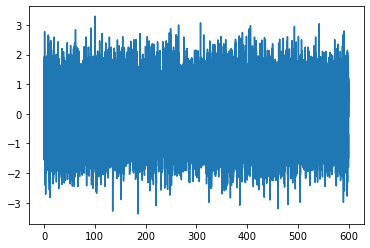

In [9]:
plt.plot(np.arange(0,sim_time,1/fs),eeg_data[:,i])

# Simple feature extraction for EEG data

In [171]:
def get_f_bands(f):
    f_sw = [k for k in range(len(f)) if f[k]<=1.5 and f[k]>0.1]
    #literature suggests a robust correlation between EEG <1.5Hz and cortical fMRI
    f_delta = [k for k in range(len(f)) if f[k]>1.5 and f[k]<=4]
    f_theta = [k for k in range(len(f)) if f[k]>4 and f[k]<=8]
    f_alpha = [k for k in range(len(f)) if f[k]>8 and f[k]<=12]
    f_beta = [k for k in range(len(f)) if f[k]>12 and f[k]<=24]
    f_gamma = [k for k in range(len(f)) if f[k]>24]
    f_bands = [f_sw,f_delta,f_theta,f_alpha,f_beta,f_gamma]
    return f_bands

def get_power_data(data,window=2,use_mne=0,r=fs):
    #data - mne readable file (if use_mne) or numpy array (ch_data,ch)
    #window = size of sample window
    #r - moving avg sliding window, default to 1 second
    if use_mne: 
        raw=mne.io.read_raw_brainvision(file,preload=True).resample(fs, npad='auto')
        eeg = raw.copy().pick_types(meg=False, eeg=True, eog=False)
        eeg_data = eeg[:][0]
    else:
        eeg_data = data
    f, t, Sxx = spectrogram_lspopt(eeg_data[:,0], fs=fs,nperseg=window*fs,noverlap=window*fs-1,c_parameter=20)
    f_bands = get_f_bands(f)
    p_len = len(pd.Series(np.sum(Sxx[f_bands[0],:],axis=0)).rolling(r).median()[r-1:])
    power_data = np.zeros((p_len,eeg_data.shape[1]*len(f_bands)))   
    for i in range(eeg_data.shape[1]):
        eeg_data[:,i] = butter_bandpass_filter(eeg_data[:,i])#optional butter bandpass
        f, t, Sxx = spectrogram_lspopt(eeg_data[:,i], fs=fs,nperseg=window*fs,noverlap=window*fs-1,c_parameter=20)
        for b in range(len(f_bands)):
            power_data[:,i*len(f_bands)+b] = pd.Series(np.sum(Sxx[f_bands[b],:],axis=0)).rolling(r).median()[r-1:]
        print('Channel ' + str(i+1)+' done')
    power_data = np.log(power_data)
    return power_data,t[r-1:]

In [172]:
data_list = [eeg_data]#eeg_data or list of files
power_data = []
t_data = []
for data in data_list:
    p,t=get_power_data(data)
    t_data.append(t)
    power_data.append(p)

Channel 1 done
Channel 2 done
Channel 3 done
Channel 4 done
Channel 5 done
Channel 6 done
Channel 7 done
Channel 8 done
Channel 9 done
Channel 10 done


# Marker extraction code (if they exists)

In [ ]:
raw=mne.io.read_raw_brainvision(EEG_files[0],preload=True)
annot = mne.read_annotations('mark_test.vmrk')
raw.set_annotations(annot)

annot = mne.read_annotations(EEG_mark[1],1000)
annot

# fMRI simulation code

In [197]:
import colorednoise as cn
fs_fMRI = 0.5
beta = 0.2 # the colored noise exponent
fMRI_samples = int(fs_fMRI*sim_time) # number of samples to generate (5 minutes of data)
rois = 20
fMRI_data = np.zeros((fMRI_samples,rois))
for i in range(rois):
    fMRI_data[:,i] = cn.powerlaw_psd_gaussian(beta, fMRI_samples)
t_vec = (t_data[0]*fs).astype('int')
fMRI_data = np.repeat(fMRI_data, 1/fs_fMRI*fs,axis=0)
fMRI_data = fMRI_data[t_vec,:]
fMRI_data = np.log(fMRI_data-np.min(fMRI_data)+1e-6)#mitigate effects of outliers
low_bands = list(np.arange(0,power_data[0].shape[1],6))+list(np.arange(1,power_data[0].shape[1],6))
fMRI_data[:,0] += np.mean(power_data[0][:,low_bands],axis=1)*0.8#encode some fMRI data into EEG
fMRI_data[:,1] += np.mean(power_data[0][:,low_bands],axis=1)*0.8#encode some fMRI data into EEG

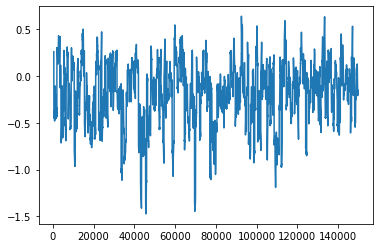

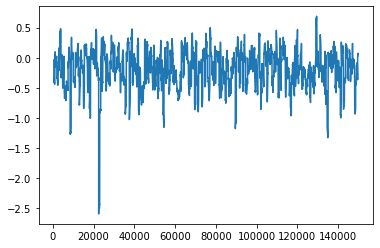

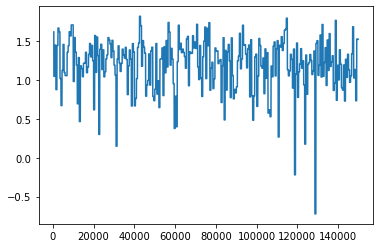

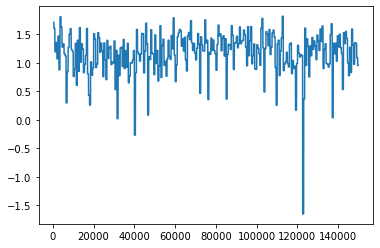

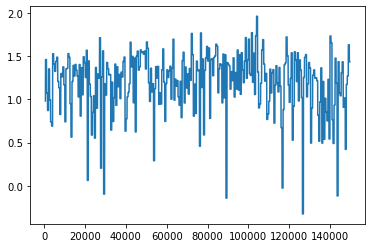

In [198]:
#show the first n simulated time series
for i in range(5):
    plt.plot(t_vec,fMRI_data[:,i])
    plt.show()

# Real fMRI data extraction code

In [54]:
fMRI_list = [fMRI_data]#change these to location of fMRI csv file

In [77]:
def get_fMRI_data(fs_MRI=3):
    fMRI_data = []
    for i in range(len(fMRI_list)):
        t_vec = (t_data[i]*fs).astype('int')
        fMRI=pd.read_csv(fMRI_files[i],header=None,sep=' ')
        cols = [0]
        fMRI.drop(fMRI.columns[cols],axis=1,inplace=True)
        fMRI = np.log(np.array(fMRI))
        fMRI= np.repeat(fMRI, 1/fs_fMRI*fs,axis=1).transpose()
        fMRI = fMRI[t_vec,:]
        fMRI-=np.mean(fMRI,axis=0)
        fMRI/=np.std(fMRI,axis=0)
        fMRI_data.append(fMRI)
    return fMRI_data

In [ ]:
fMRI_data = get_fMRI_data()

# Randomise training, validation and testing sets

An important point is that because of temporal dependence data cannot be sampled independently for creating validation and testing sets. We choose a compromise which segments data into a |training|validation|test| set with a random boundary between validation and training data.

In [199]:
fMRI_data = [fMRI_data]#change these to location of fMRI csv file

In [200]:
def rand_parts(seq, val_len,test_len):
    #creates test and validation index sets
    test_val_len = val_len+test_len
    indices = range(len(seq) - (test_val_len - 1))
    result = []
    offset = 0
    s = random.sample(indices, 1)[0]    
    result.append(seq[s:s+val_len])
    result.append(seq[s+val_len:s+val_len+test_len])
    return result

In [201]:
from sklearn.preprocessing import scale
test_val_frac = 0.2
test_inds = []
power_test = []
power_train = []
power_val = []
fMRI_test = []
fMRI_val = []
fMRI_train = []
for i in range(len(fMRI_data)):
    inds = (t_data[i]*fs).astype(int)
    test_val_size = int(len(t_data[i])*test_val_frac)
    tv_inds = rand_parts(inds,test_val_size,test_val_size)
    power_test.append(scale(power_data[i][tv_inds[0],:]))
    power_val.append(scale(power_data[i][tv_inds[1],:]))
    power_train.append(scale(np.array([power_data[i][k,:] for k,x in enumerate(t_data[i]) 
                                 if k not in tv_inds[0] and k not in tv_inds[1]])))
    fMRI_test.append(scale(fMRI_data[i][tv_inds[0],:]))
    fMRI_val.append(scale(fMRI_data[i][tv_inds[1],:]))
    fMRI_train.append(scale(np.array([fMRI_data[i][k,:] for k,x in enumerate(t_data[i]) 
                                 if k not in tv_inds[0] and k not in tv_inds[1]])))

In [202]:
#concatenate all data sets for model training/testing/validation
power_train = np.concatenate(power_train)
fMRI_train = np.concatenate(fMRI_train)
power_val = np.concatenate(power_val)
fMRI_val = np.concatenate(fMRI_val)
power_test = np.concatenate(power_test)
fMRI_test = np.concatenate(fMRI_test)

In [203]:
#Optionally train only on low frequency EEG bands
power_train = power_train[:,low_bands]
power_val = power_val[:,low_bands]
power_test = power_test[:,low_bands]

In [204]:
random.seed(10062020)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, input_shape=(power_train.shape[1],),activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(fMRI_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
model.compile(optimizer='Adam', loss=l)

In [205]:
random.seed(10062020)
model.fit(power_train, fMRI_train, batch_size=128, epochs=50)

Epoch 1/50
703/703 [==============================] - 1s 2ms/step - loss: 0.3077
Epoch 2/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2710
Epoch 3/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2546
Epoch 4/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2435
Epoch 5/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2362
Epoch 6/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2301
Epoch 7/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2255
Epoch 8/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2214
Epoch 9/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2177
Epoch 10/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2149
Epoch 11/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2108
Epoch 12/50
703/703 [==============================] - 1s 1ms/step - loss: 0.2080
Epoch 13/50
703/703 [====

In [206]:
model.save('./model1')

INFO:tensorflow:Assets written to: ./model1\assets


In [207]:
y_pred=model.predict(power_train)
y = fMRI_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

tf.Tensor(0.091037996, shape=(), dtype=float32)
[[1.         0.92462647]
 [0.92462647 1.        ]]


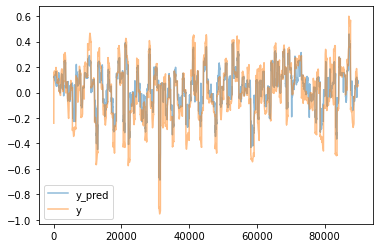

In [208]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(fMRI_data)[:,2],label='y')
plt.legend()

# Simple models based on simulated data does not generalise well
The model based on simulated data does not generalise well.

In [209]:
y_pred=model.predict(power_val)
y = fMRI_val
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

tf.Tensor(0.37706167, shape=(), dtype=float32)
[[1.         0.00846975]
 [0.00846975 1.        ]]


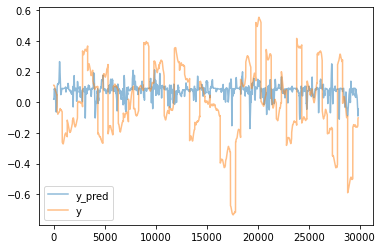

In [210]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(fMRI_data)[:,2],label='y')
plt.legend()

# Cortical fMRI ROI Only Fitting

This model is based on real cortical fMRI ROIs from the Harvard-Oxford cortical parcellation.

In [20]:
cort_train = fMRI_train[:,:48]
cort_val = fMRI_val[:,:48]
cort_test = fMRI_test[:,:48]
sub_train = fMRI_train[:,48:]
sub_val = fMRI_val[:,48:]
sub_test = fMRI_test[:,48:]

In [22]:
random.seed(10062020)
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128, input_shape=(cort_train.shape[1],),activation="relu"))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(128,activation="relu"))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(sub_train.shape[1],activation="linear"))
l = tf.keras.losses.LogCosh()
model2.compile(optimizer='Adam', loss=l)

In [ ]:
random.seed(10062020)
model2.fit(cort_train, sub_train, batch_size=128, epochs=30)

In [24]:
model2.save('/homes/wilsenac/fMRI/model2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /homes/wilsenac/fMRI/model2/assets


In [25]:
model2 = tf.keras.models.load_model('/data/fiscal/wilsenac/local/model2')

In [43]:
y_pred=cort_train
y = sub_train
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
# print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

[[1.         0.74886056]
 [0.74886056 1.        ]]


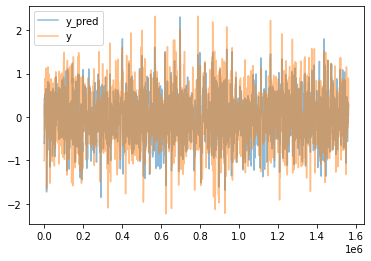

In [27]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(fMRI_data)[:,2],label='y')
plt.legend()

In [28]:
y_pred=model2.predict(cort_val)
y = sub_val
y_pred_mean=np.mean(y_pred,axis=1)
y_mean = np.mean(y,axis=1)
print(l(y,y_pred))
print(np.corrcoef(y_mean,y_pred_mean))

tf.Tensor(0.30879557, shape=(), dtype=float32)
[[1.         0.77895602]
 [0.77895602 1.        ]]


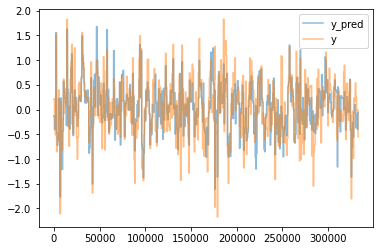

In [29]:
plt.plot(y_pred_mean,label='y_pred',alpha=0.5)
plt.plot(y_mean,label='y',alpha=0.5)
# plt.plot(np.transpose(fMRI_data)[:,2],label='y')
plt.legend()

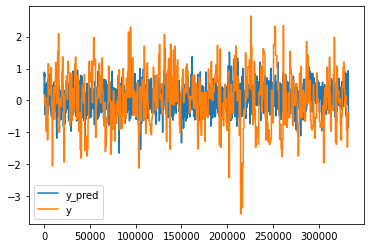

In [61]:
i=1
y_pred=model.predict(power_test)[:,i]
y=fMRI_test[:,i]
plt.plot(y_pred,label='y_pred')
plt.plot(y,label='y')
# plt.plot(np.transpose(fMRI_data)[:,2],label='y')
plt.legend()

In [60]:
np.corrcoef(y_pred,y)

array([[1.        , 0.02315238],
       [0.02315238, 1.        ]])

# Conclusion

Real data generalises marginally better than simulated fMRI/EEG data based on mostly uncorrelated colored noise. More sophisticated models e.g. deep RNNs may help to generalise further.